In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv('Mall_Customers.csv')

# Преобразование категориальных переменных
label_encoders = {}
for col in ['Genre']:  # Предполагается, что 'Genre' является категориальной переменной
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # преобразование значений категориальной переменной в числа
    label_encoders[col] = le

# Разделение на признаки и целевую переменную
# В данном примере используем 'Spending Score (1-100)' как целевую переменную
X = df.drop(columns=['Spending Score (1-100)', 'CustomerID'])  # все столбцы, кроме 'Spending Score (1-100)' и 'CustomerID'
y = (df['Spending Score (1-100)'] > df['Spending Score (1-100)'].median()).astype(int)  # 1 если Spending Score выше медианы, 0 если ниже

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размеры выборок: X_train: {X_train.shape}, X_test: {X_test.shape}")

Размеры выборок: X_train: (160, 3), X_test: (40, 3)


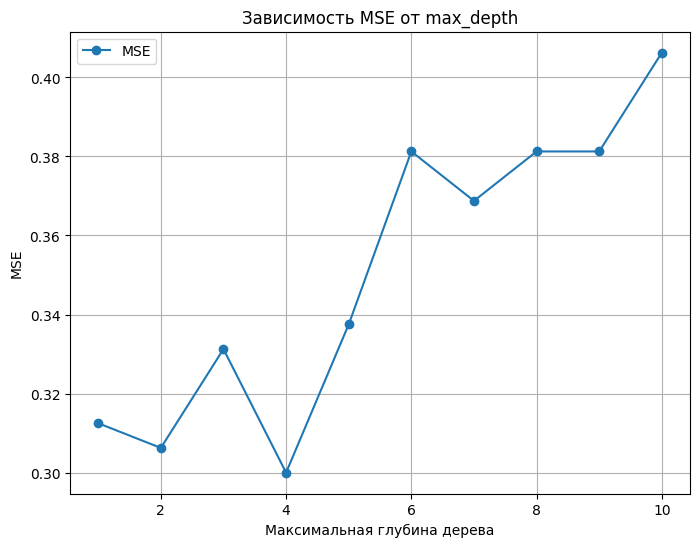

In [2]:
depths = range(1, 11)
mse_scores = []

# Обучение модели и вычисление MSE для разных глубин дерева
for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)  # дерево решений с заданной глубиной
    # выполнение 5-кратной кросс-валидации
    mse = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))  # возвращает отрицательные значения MSE
    mse_scores.append(mse)  # добавляем значение MSE в список

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(depths, mse_scores, marker='o', label='MSE')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('MSE')
plt.title('Зависимость MSE от max_depth')
plt.legend()
plt.grid()
plt.show()

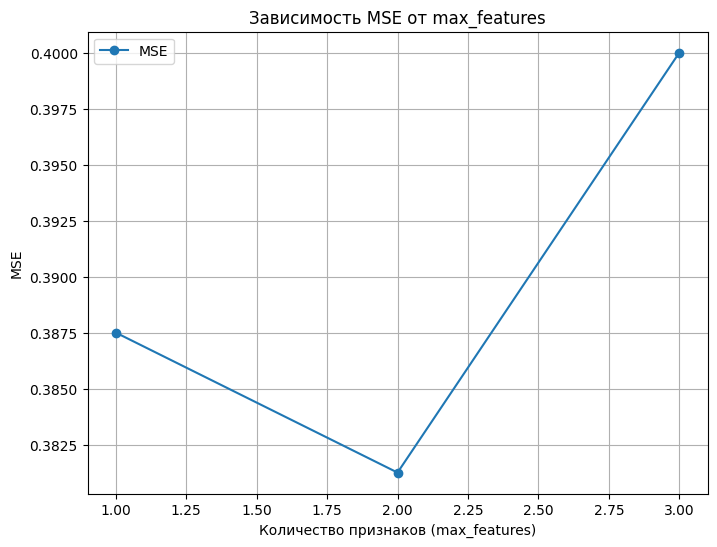

In [3]:
# Количество признаков, которые модель может использовать на каждом этапе построения дерева
features_range = range(1, X_train.shape[1] + 1)  # X_train.shape[1] возвращает количество признаков в обучающем наборе данных
mse_scores_features = []  # массив со значениями MSE для каждой настройки max_features

# Обучение модели с разным количеством признаков на каждом этапе построения дерева
for max_features in features_range:
    model = DecisionTreeClassifier(max_features=max_features, random_state=42)  # дерево решений с max_features
    mse = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))  # вычисление MSE с кросс-валидацией
    mse_scores_features.append(mse)

# Построение графика зависимости MSE от max_features
plt.figure(figsize=(8, 6))
plt.plot(features_range, mse_scores_features, marker='o', label='MSE')
plt.xlabel('Количество признаков (max_features)')
plt.ylabel('MSE')
plt.title('Зависимость MSE от max_features')
plt.legend()
plt.grid()
plt.show()

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Сетка параметров
param_grid = {
    'max_depth': range(1, 11),  # Диапазон для max_depth
    'max_features': range(1, X_train.shape[1] + 1)  # Количество признаков, которые можно использовать в модели
}

# Поиск лучших параметров с помощью дерева решений и MSE
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и лучшего MSE
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший MSE: {-grid_search.best_score_}")

# Использование оптимальной модели
best_model = grid_search.best_estimator_

Лучшие параметры: {'max_depth': 4, 'max_features': 3}
Лучший MSE: 0.3


In [5]:
from sklearn.tree import export_graphviz
import graphviz

# Сохранение оптимального дерева в формате .dot
export_graphviz(
    best_model,  # Используем лучшую модель
    out_file="optimal_decision_tree.dot",  # Имя выходного файла
    feature_names=X.columns,  # Имена признаков (используем X, так как это ваш набор признаков)
    class_names=['Low', 'High'],  # Имена классов: 'Low' и 'High' для задачи бинарной классификации
    filled=True,  # Цветовая заливка
    rounded=True,  # Закругленные узлы
    special_characters=False  # Отключение специальных символов
)

# Конвертация .dot в .png с использованием graphviz
with open("optimal_decision_tree.dot") as f:
    dot_graph = f.read()

graph = graphviz.Source(dot_graph)
graph.render("optimal_decision_tree", format="png")  # Генерация .png

print("Оптимальное дерево сохранено в файл 'optimal_decision_tree.png'.")

Оптимальное дерево сохранено в файл 'optimal_decision_tree.png'.


In [6]:
from sklearn.tree import export_graphviz

# Обучение модели
best_model.fit(X_train, y_train)  # Используем модель, обученную на ваших данных

# Сохранение дерева в формате .dot без использования специальных символов
export_graphviz(
    best_model,  # Обученная модель (лучшее дерево решений)
    out_file="decision_tree.dot",  # Файл сохранения
    feature_names=X.columns,  # Имена признаков, используем X, так как это DataFrame с признаками
    class_names=['Low', 'High'],  # Имена классов: 'Low' и 'High', для вашего бинарного классификатора
    filled=True,  # Цветовая заливка узлов дерева
    rounded=True,  # Закругленные узлы
    special_characters=False  # Отключение специальных символов
)

print("Упрощенное дерево сохранено в файл 'decision_tree.dot'.")

Упрощенное дерево сохранено в файл 'decision_tree.dot'.
